In [ ]:
!pip install tensorflow==2.5.0
!pip install numpy==1.20.3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import shutil
shutil.copy2("/content/drive/MyDrive/utilities.py", "/content/utilities.py")
shutil.copy2("/content/drive/MyDrive/ConvNet.py", "/content/ConvNet.py")
shutil.copy2("/content/drive/MyDrive/config.py", "/content/config.py")

'/content/config.py'

In [2]:
import ConvNet
import config
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Audio, clear_output, display
from glob import glob
import random
from utilities import acuracia0, acuracia1, acuracia2
import utilities

In [3]:
model = ConvNet.ConvNet

In [ ]:
model.summary()

# k=1

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/treino1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/teste1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/validation1.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [ ]:
TRAIN_DATASET = os.path.join("/content", "treino1")
VAL_DATASET = os.path.join("/content", "validation1")
TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [ ]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [ ]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [ ]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [ ]:
list_images_train = list(images_train.as_numpy_iterator())

In [ ]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
list_images_test = list(images_test.as_numpy_iterator())

In [ ]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7060, 40, 256, 1)
(883, 40, 256, 1)
(7060,)
(883,)
(883,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [ ]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [ ]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 41s - loss: 5.1228 - accuracy: 0.0052    

111/111 [==============================] - 9s 75ms/step
Train - Acurácia 0:  0.2745042492917847
Train - Acurácia 2:  0.5715297450424929
14/14 [==============================] - 1s 75ms/step
Validation - Acurácia 0:  0.24235560588901472
validation - Acurácia 2:  0.5673839184597962
111/111 [==============================] - 79s 566ms/step - loss: 3.8836 - accuracy: 0.2181 - val_loss: 4.1470 - val_accuracy: 0.2424
Epoch 2/50
111/111 [==============================] - 8s 77ms/step
Train - Acurácia 0:  0.3341359773371105
Train - Acurácia 2:  0.6301699716713881
14/14 [==============================] - 1s 77ms/step
Validation - Acurácia 0:  0.29898074745186864
validation - Acurácia 2:  0.5968289920724802
111/111 [==============================] - 59s 533ms/step - loss: 2.7932 - accuracy: 0.3542 - val_loss: 3.3222 - val_accuracy: 0.2990
Epoch 3/50
111/111 [==============================] - 9s 79ms/step
Train - Acurácia 0:  0.4245042492917847
Train - Acurácia 2:  0.7820113314447592
14/14 [=====

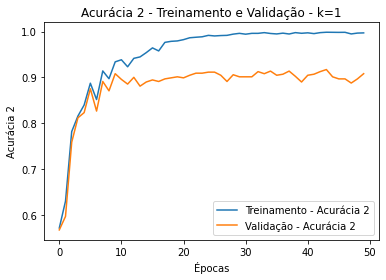

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'1')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k1'+'.pdf', format='pdf')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k1',acc)
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/val_acc2_'+'k1',val_acc)

In [ ]:
model.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k1')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k1')

### Training Results

In [ ]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 80ms/step
(7060, 140)
(7060,)
(7060,)


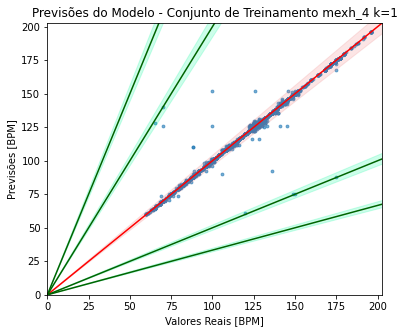

In [ ]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento mexh_4 k=1', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_train_'+'k1'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_mexh_4_k=1'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_mexh_4_k=1    0.941926    0.996459     0.997309


### Validation Results

In [ ]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 80ms/step
(883, 140)
(883, 140)
(883,)
(883,)


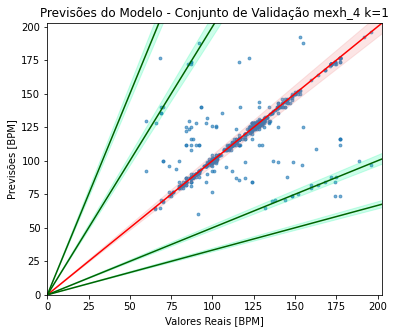

In [ ]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação mexh_4 k=1', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_validation_'+'k1'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_mexh_4_k=1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=1    0.941926    0.996459     0.997309
1  validation_mexh_4_k=1    0.530011    0.881087     0.908267


### Test Results

In [ ]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 79ms/step
(883, 140)
(883, 140)
(883,)
(883,)


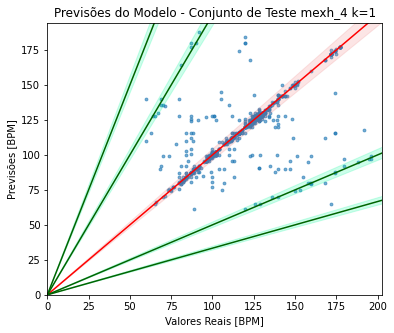

In [ ]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste mexh_4 k=1', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_test_'+'k1'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_mexh_4_k=1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=1    0.941926    0.996459     0.997309
1  validation_mexh_4_k=1    0.530011    0.881087     0.908267
2        test_mexh_4_k=1    0.523216    0.847112     0.878822


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/mexh_4_kfold/Resultados_mexh_4_k1.xlsx", index=False)  

# k=2

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/treino2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/teste2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/validation2.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [ ]:
TRAIN_DATASET = os.path.join("/content", "treino2")
VAL_DATASET = os.path.join("/content", "validation2")
TEST_DATASET = os.path.join("/content", "teste2")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [ ]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [ ]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [ ]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [ ]:
list_images_train = list(images_train.as_numpy_iterator())

In [ ]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
list_images_test = list(images_test.as_numpy_iterator())

In [ ]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [ ]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [ ]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 42s - loss: 5.1362 - accuracy: 0.0286

111/111 [==============================] - 9s 76ms/step
Train - Acurácia 0:  0.224440668365902
Train - Acurácia 2:  0.4331634097989238
14/14 [==============================] - 1s 76ms/step
Validation - Acurácia 0:  0.21541950113378686
validation - Acurácia 2:  0.42063492063492064
111/111 [==============================] - 74s 571ms/step - loss: 3.9812 - accuracy: 0.2091 - val_loss: 7.5199 - val_accuracy: 0.2154
Epoch 2/50
111/111 [==============================] - 9s 78ms/step
Train - Acurácia 0:  0.33715661285754744
Train - Acurácia 2:  0.6785613140753328
14/14 [==============================] - 1s 78ms/step
Validation - Acurácia 0:  0.32653061224489793
validation - Acurácia 2:  0.6859410430839002
111/111 [==============================] - 60s 538ms/step - loss: 2.7905 - accuracy: 0.3411 - val_loss: 2.9401 - val_accuracy: 0.3265
Epoch 3/50
111/111 [==============================] - 9s 79ms/step
Train - Acurácia 0:  0.4041348060039649
Train - Acurácia 2:  0.7783913905409232
14/14 [====

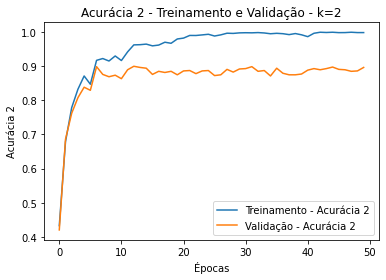

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'2')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k2'+'.pdf', format='pdf')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k2',acc)
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/val_acc2_'+'k2',val_acc)

In [ ]:
model.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k2')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k2')

### Training Results

In [ ]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 80ms/step
(7062, 140)
(7062,)
(7062,)


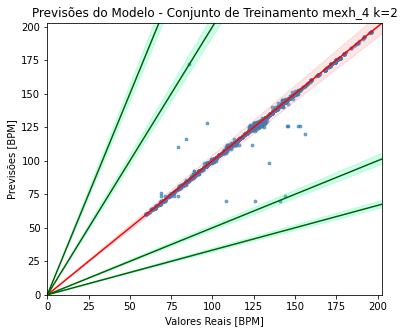

In [ ]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento mexh_4 k=2', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_train_'+'k2'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_mexh_4_k=2'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_mexh_4_k=2    0.945908    0.997168     0.997593


### Validation Results

In [ ]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 79ms/step
(882, 140)
(882, 140)
(882,)
(882,)


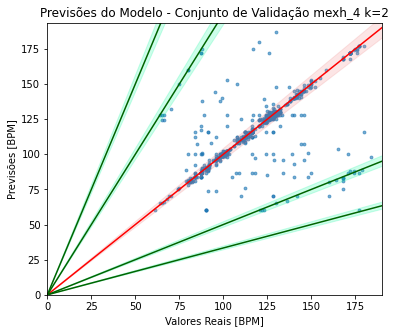

In [ ]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação mexh_4 k=2', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_validation_'+'k2'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_mexh_4_k=2'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=2    0.945908    0.997168     0.997593
1  validation_mexh_4_k=2    0.496599    0.863946     0.895692


### Test Results

In [ ]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 80ms/step
(882, 140)
(882, 140)
(882,)
(882,)


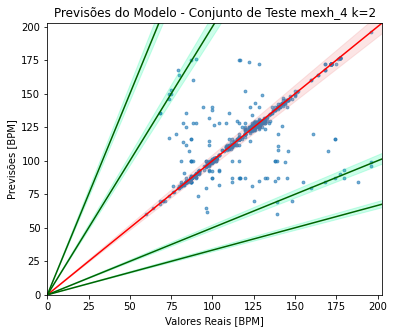

In [ ]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste mexh_4 k=2', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_test_'+'k2'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_mexh_4_k=2'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=2    0.945908    0.997168     0.997593
1  validation_mexh_4_k=2    0.496599    0.863946     0.895692
2        test_mexh_4_k=2    0.544218    0.869615     0.890023


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/mexh_4_kfold/Resultados_mexh_4_k2.xlsx", index=False)  

# k=3

In [ ]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/treino3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/teste3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/validation3.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [ ]:
TRAIN_DATASET = os.path.join("/content", "treino3")
VAL_DATASET = os.path.join("/content", "validation3")
TEST_DATASET = os.path.join("/content", "teste3")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [ ]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [ ]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [ ]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [ ]:
list_images_train = list(images_train.as_numpy_iterator())

In [ ]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
list_images_test = list(images_test.as_numpy_iterator())

In [ ]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [ ]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [ ]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 42s - loss: 5.1497 - accuracy: 0.0104

111/111 [==============================] - 9s 76ms/step
Train - Acurácia 0:  0.22698952138204476
Train - Acurácia 2:  0.4847068819031436
14/14 [==============================] - 1s 76ms/step
Validation - Acurácia 0:  0.20975056689342403
validation - Acurácia 2:  0.47165532879818595
111/111 [==============================] - 74s 570ms/step - loss: 4.0118 - accuracy: 0.1866 - val_loss: 4.6782 - val_accuracy: 0.2098
Epoch 2/50
111/111 [==============================] - 9s 78ms/step
Train - Acurácia 0:  0.30954403851600115
Train - Acurácia 2:  0.6097422826394789
14/14 [==============================] - 1s 78ms/step
Validation - Acurácia 0:  0.26303854875283444
validation - Acurácia 2:  0.5929705215419501
111/111 [==============================] - 60s 538ms/step - loss: 2.9074 - accuracy: 0.3236 - val_loss: 3.0656 - val_accuracy: 0.2630
Epoch 3/50
111/111 [==============================] - 9s 80ms/step
Train - Acurácia 0:  0.3092608326253186
Train - Acurácia 2:  0.6299915038232795
14/14 [==

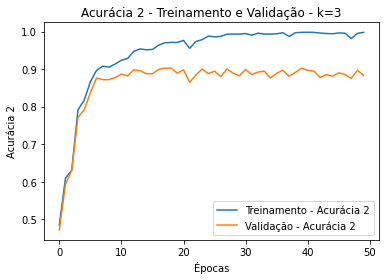

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'3')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k3'+'.pdf', format='pdf')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k3',acc)
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/val_acc2_'+'k3',val_acc)

In [ ]:
model.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k3')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k3')

### Training Results

In [ ]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 80ms/step
(7062, 140)
(7062,)
(7062,)


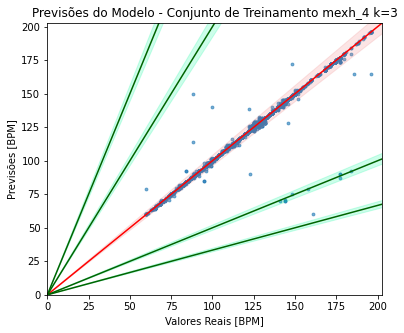

In [ ]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento mexh_4 k=3', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_train_'+'k3'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_mexh_4_k=3'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_mexh_4_k=3    0.937411    0.996177     0.997734


### Validation Results

In [ ]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 79ms/step
(882, 140)
(882, 140)
(882,)
(882,)


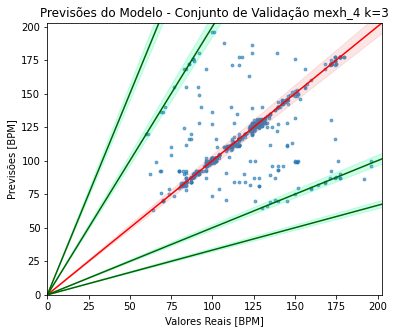

In [ ]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação mexh_4 k=3', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_validation_'+'k3'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_mexh_4_k=3'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=3    0.937411    0.996177     0.997734
1  validation_mexh_4_k=3    0.497732    0.843537     0.883220


### Test Results

In [ ]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 80ms/step
(882, 140)
(882, 140)
(882,)
(882,)


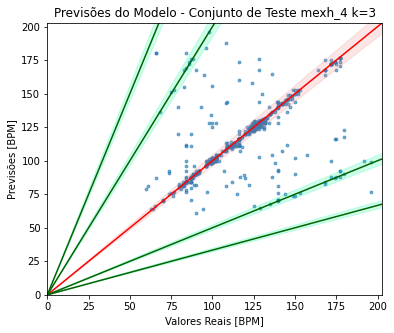

In [ ]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste mexh_4 k=3', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_test_'+'k3'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_mexh_4_k=3'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=3    0.937411    0.996177     0.997734
1  validation_mexh_4_k=3    0.497732    0.843537     0.883220
2        test_mexh_4_k=3    0.523810    0.858277     0.895692


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/mexh_4_kfold/Resultados_mexh_4_k3.xlsx", index=False)  

# k=4

In [5]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/treino4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/teste4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/validation4.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "treino4")
VAL_DATASET = os.path.join("/content", "validation4")
TEST_DATASET = os.path.join("/content", "teste4")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [8]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [9]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [10]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [13]:
list_images_test = list(images_test.as_numpy_iterator())

In [14]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [15]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [16]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [17]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [18]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [19]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 41s - loss: 5.1233 - accuracy: 0.0208

111/111 [==============================] - 9s 77ms/step
Train - Acurácia 0:  0.14684225431888984
Train - Acurácia 2:  0.46190880770320025
14/14 [==============================] - 1s 77ms/step
Validation - Acurácia 0:  0.16666666666666666
validation - Acurácia 2:  0.46938775510204084
111/111 [==============================] - 80s 568ms/step - loss: 3.9067 - accuracy: 0.2053 - val_loss: 5.6852 - val_accuracy: 0.1667
Epoch 2/50
111/111 [==============================] - 9s 78ms/step
Train - Acurácia 0:  0.3323421127159445
Train - Acurácia 2:  0.7126876239025772
14/14 [==============================] - 1s 78ms/step
Validation - Acurácia 0:  0.35487528344671204
validation - Acurácia 2:  0.699546485260771
111/111 [==============================] - 61s 552ms/step - loss: 2.8574 - accuracy: 0.3383 - val_loss: 2.9144 - val_accuracy: 0.3549
Epoch 3/50
111/111 [==============================] - 9s 79ms/step
Train - Acurácia 0:  0.416029453412631
Train - Acurácia 2:  0.7963749645992637
14/14 [====

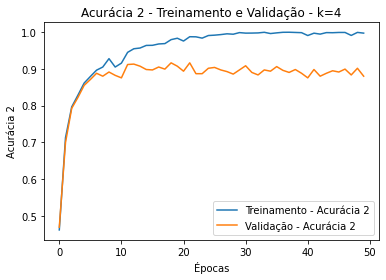

In [20]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'4')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k4'+'.pdf', format='pdf')
plt.show()

In [21]:
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k4',acc)
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/val_acc2_'+'k4',val_acc)

In [22]:
model.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k4')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k4')

### Training Results

In [23]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 78ms/step
(7062, 140)
(7062,)
(7062,)


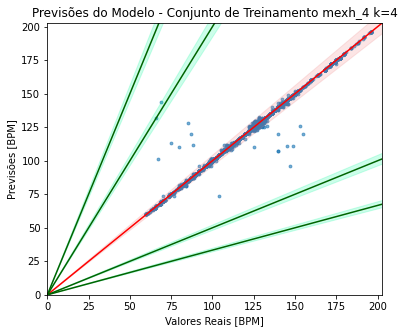

In [24]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento mexh_4 k=4', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_train_'+'k4'+'.pdf')

In [25]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_mexh_4_k=4'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_mexh_4_k=4    0.939394    0.996743     0.996885


### Validation Results

In [26]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 78ms/step
(882, 140)
(882, 140)
(882,)
(882,)


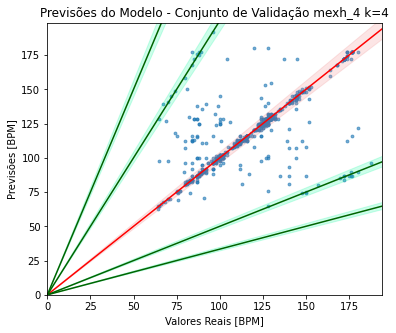

In [27]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação mexh_4 k=4', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_validation_'+'k4'+'.pdf')

In [28]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_mexh_4_k=4'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=4    0.939394    0.996743     0.996885
1  validation_mexh_4_k=4    0.529478    0.849206     0.879819


### Test Results

In [29]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 78ms/step
(882, 140)
(882, 140)
(882,)
(882,)


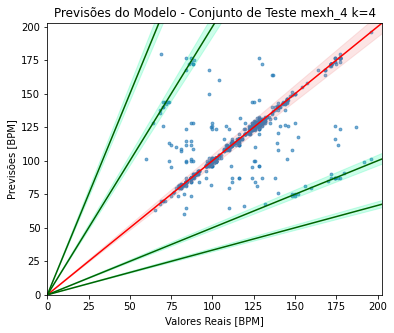

In [30]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste mexh_4 k=4', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_test_'+'k4'+'.pdf')

In [31]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_mexh_4_k=4'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=4    0.939394    0.996743     0.996885
1  validation_mexh_4_k=4    0.529478    0.849206     0.879819
2        test_mexh_4_k=4    0.529478    0.852608     0.888889


In [32]:
resultados.to_excel("/content/drive/MyDrive/Resultados/mexh_4_kfold/Resultados_mexh_4_k4.xlsx", index=False)  

# k=5

In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/treino5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/teste5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/training_mexh_4_review_split/validation5.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()

### Tensors Definitions

In [5]:
TRAIN_DATASET = os.path.join("/content", "treino5")
VAL_DATASET = os.path.join("/content", "validation5")
TEST_DATASET = os.path.join("/content", "teste5")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)


def make_dataset_aug(path, batch_size):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=0.75:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [6]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [7]:
def make_dataset_simple(path, batch_size):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
    classes = sorted(classes)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes,images_ds,labels_ds

In [8]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS) #labels com valores 0 a 234
testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [9]:
print(classes_t)
print(classes)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [10]:
list_images_train = list(images_train.as_numpy_iterator())

In [11]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [12]:
list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

list_labels_test= list(labels_test.as_numpy_iterator())
labels_test_true = []
for i in list_labels_test:
       labels_test_true.append(classes[i])
labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
print(testDS)

(7062, 40, 256, 1)
(882, 40, 256, 1)
(7062,)
(882,)
(882,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainDS, validation_data=validationDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict,  validation_steps=validation_steps ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/111 [>.............................] - ETA: 46s - loss: 5.0393 - accuracy: 0.0417

111/111 [==============================] - 9s 77ms/step
Train - Acurácia 0:  0.28872840555083545
Train - Acurácia 2:  0.6067686207873124
14/14 [==============================] - 1s 78ms/step
Validation - Acurácia 0:  0.2471655328798186
validation - Acurácia 2:  0.5839002267573696
111/111 [==============================] - 79s 609ms/step - loss: 3.6876 - accuracy: 0.2438 - val_loss: 4.2777 - val_accuracy: 0.2472
Epoch 2/50
111/111 [==============================] - 9s 78ms/step
Train - Acurácia 0:  0.38204474653072784
Train - Acurácia 2:  0.7309544038516002
14/14 [==============================] - 1s 78ms/step
Validation - Acurácia 0:  0.3458049886621315
validation - Acurácia 2:  0.7278911564625851
111/111 [==============================] - 61s 552ms/step - loss: 2.6764 - accuracy: 0.3668 - val_loss: 2.7299 - val_accuracy: 0.3458
Epoch 3/50
111/111 [==============================] - 9s 79ms/step
Train - Acurácia 0:  0.45539507221750214
Train - Acurácia 2:  0.829368450863778
14/14 [=====

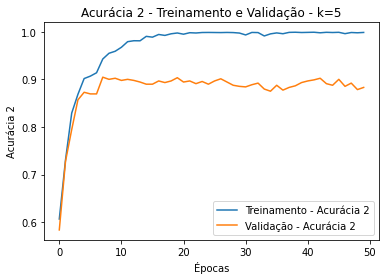

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - k='+'5')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k5'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/acc2_'+'k5',acc)
np.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/val_acc2_'+'k5',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k5')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/mexh_4_kfold/mexh_4_kfold_'+'k5')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

111/111 [==============================] - 9s 79ms/step
(7062, 140)
(7062,)
(7062,)


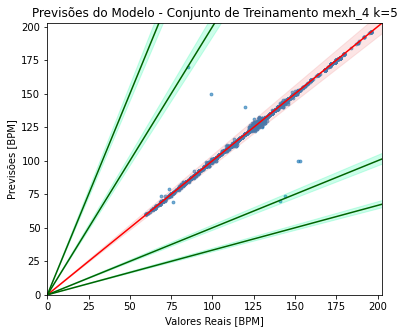

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento mexh_4 k=5', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_train_'+'k5'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_mexh_4_k=5'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

        Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_mexh_4_k=5    0.942934    0.998301     0.998726


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

14/14 [==============================] - 1s 78ms/step
(882, 140)
(882, 140)
(882,)
(882,)


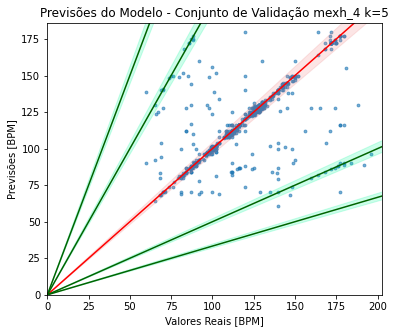

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação mexh_4 k=5', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_validation_'+'k5'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_mexh_4_k=5'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=5    0.942934    0.998301     0.998726
1  validation_mexh_4_k=5    0.488662    0.849206     0.883220


### Test Results

In [28]:
num_images_test = len(glob(TEST_DATASET + '/*/*'))
test_steps = math.ceil(num_images_test/config.BS)

test_predictions = model.predict(images_test_ds, batch_size=config.BS, steps=test_steps, verbose=1)
print(test_predictions.shape)
arg_max = np.argmax(test_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = test_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            test_predictions[i][j]=1
        else:
            test_predictions[i][j]=0  

print(test_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

test_pred_new = mlb.inverse_transform(test_predictions)
test_pred_new = np.array(test_pred_new, int)
test_pred_new = np.reshape(test_pred_new, (test_pred_new.size,))

print(test_pred_new.shape)
print(labels_test_true.shape)

14/14 [==============================] - 1s 78ms/step
(882, 140)
(882, 140)
(882,)
(882,)


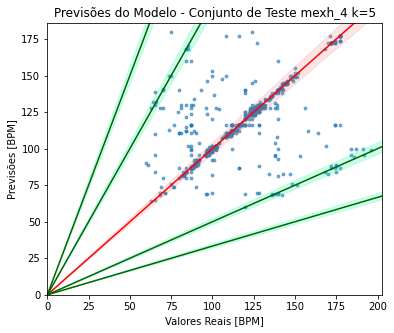

In [29]:
utilities.MakeGraphicPredictions(labels_test_true, test_pred_new, 'Previsões do Modelo - Conjunto de Teste mexh_4 k=5', '/content/drive/MyDrive/Resultados/mexh_4_kfold/prev_test_'+'k5'+'.pdf')

In [30]:
acc0 = utilities.acuracia0(labels_test_true, test_pred_new)
acc1 = utilities.acuracia1(labels_test_true, test_pred_new)
acc2 = utilities.acuracia2(labels_test_true, test_pred_new)

experimento = 'test_mexh_4_k=5'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

             Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_mexh_4_k=5    0.942934    0.998301     0.998726
1  validation_mexh_4_k=5    0.488662    0.849206     0.883220
2        test_mexh_4_k=5    0.513605    0.821995     0.861678


In [31]:
resultados.to_excel("/content/drive/MyDrive/Resultados/mexh_4_kfold/Resultados_mexh_4_k5.xlsx", index=False)  